<a href="https://colab.research.google.com/github/stfromnjust/nlp-task/blob/main/Seq2SeqForTranslation_general.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 下载数据 必要配置

In [1]:
# 查看GPU配置
!/opt/bin/nvidia-smi

Sun Jun  6 12:28:57 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# 下载数据集
!wget https://github.com/stfromnjust/nlp-task/raw/main/cmn-eng.zip
!unzip -d ./cmn-eng cmn-eng.zip

--2021-06-06 12:28:58--  https://github.com/stfromnjust/nlp-task/raw/main/cmn-eng.zip
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/stfromnjust/nlp-task/main/cmn-eng.zip [following]
--2021-06-06 12:28:58--  https://raw.githubusercontent.com/stfromnjust/nlp-task/main/cmn-eng.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1049235 (1.0M) [application/zip]
Saving to: ‘cmn-eng.zip’

cmn-eng.zip         100%[===================>]   1.00M  --.-KB/s    in 0.05s   

2021-06-06 12:28:59 (21.6 MB/s) - ‘cmn-eng.zip’ saved [1049235/1049235]

Archive:  cmn-eng.zip
   creating: ./cmn-eng/cmn-eng/
  infl

In [3]:
# 下载中文字体
!wget https://github.com/stfromnjust/nlp-task/raw/main/simheittf.zip
!unzip -d ./simheittf simheittf.zip

--2021-06-06 12:28:59--  https://github.com/stfromnjust/nlp-task/raw/main/simheittf.zip
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/stfromnjust/nlp-task/main/simheittf.zip [following]
--2021-06-06 12:28:59--  https://raw.githubusercontent.com/stfromnjust/nlp-task/main/simheittf.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5129593 (4.9M) [application/zip]
Saving to: ‘simheittf.zip’

simheittf.zip       100%[===================>]   4.89M  --.-KB/s    in 0.1s    

2021-06-06 12:29:00 (47.8 MB/s) - ‘simheittf.zip’ saved [5129593/5129593]

Archive:  simheittf.zip
   creating: ./simheittf/s

In [4]:
seed = 2030

In [5]:
!pip install opencc

     |████████████████████████████████| 768kB 14.9MB/s 


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchtext.legacy.data import *

import time
import math
import random
import numpy as np

import jieba
import spacy
import opencc
from nltk.translate.bleu_score import corpus_bleu

import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# 读取数据

In [8]:
# 每一行数据如下
# 'Hi.\t嗨。\tCC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #891077 (Martha)'
with open('./cmn-eng/cmn-eng/cmn.txt', 'r', encoding='utf-8') as f:
    data = f.read()
data = data.strip()
data = data.split('\n')
print('样本数:\n', len(data))
print('\n样本示例:')
data[0]

样本数:
 24818

样本示例:


'Hi.\t嗨。\tCC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #891077 (Martha)'

In [9]:
# 分割英文数据和中文数据
# 繁体中文转简体中文
# 英文改为全小写
cc = opencc.OpenCC('t2s')

en_data = [line.split('\t')[0].lower() for line in data]
ch_data = [cc.convert(line.split('\t')[1]) for line in data]

print('英文数据:\n', en_data[:10])
print('\n中文数据:\n', ch_data[:10])

英文数据:
 ['hi.', 'hi.', 'run.', 'wait!', 'wait!', 'hello!', 'i try.', 'i won!', 'oh no!', 'cheers!']

中文数据:
 ['嗨。', '你好。', '你用跑的。', '等等！', '等一下！', '你好。', '让我来。', '我赢了。', '不会吧。', '干杯!']


# 分词

In [10]:
# 中文使用jieba分词
ch_token_list = []
for line in ch_data:
  ch_token_list.append(list(jieba.cut(line)) + ['<eos>'])

# 英文使用spacy分词
nlp = spacy.load('en')
en_token_list = []
for line in en_data:
  doc = nlp(line)
  en_new = []
  for token in doc:
    en_new.append(token.text)
  en_token_list.append(en_new + ['<eos>'])

# 测试
print('英文数据:\n', en_token_list[:3])
print('中文数据:\n', ch_token_list[:3])

Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.801 seconds.
Prefix dict has been built successfully.


英文数据:
 [['hi', '.', '<eos>'], ['hi', '.', '<eos>'], ['run', '.', '<eos>']]
中文数据:
 [['嗨', '。', '<eos>'], ['你好', '。', '<eos>'], ['你', '用', '跑', '的', '。', '<eos>']]


# 建立词典

In [11]:
# 利用torchtext的build_vocab函数创建词典
ch_TEXT = Field()
ch_TEXT.build_vocab(ch_token_list[:21622], specials=['<pad>', '<unk>', '<bos>', '<eos>'])
en_TEXT = Field()
en_TEXT.build_vocab(en_token_list[:21622], specials=['<pad>', '<unk>', '<bos>', '<eos>'])

print('英文词典: ')
print('英文词数量: ', len(en_TEXT.vocab))
print('英文词典前20个: ', en_TEXT.vocab.itos[:20])
print('英文<unk>编号:', en_TEXT.vocab.stoi['<unk>'])

print('\n中文词典: ')
print('中文词数量: ', len(ch_TEXT.vocab))
print('中文词典前20个', ch_TEXT.vocab.itos[:20])
print('中文<unk>编号:', ch_TEXT.vocab.stoi['<unk>'])

英文词典: 
英文词数量:  6288
英文词典前20个:  ['<unk>', '<pad>', '<bos>', '<eos>', '.', 'i', 'the', 'to', 'you', 'a', '?', 'is', 'he', "n't", 'tom', 'do', 'it', 'in', "'s", 'of']
英文<unk>编号: 0

中文词典: 
中文词数量:  10742
中文词典前20个 ['<unk>', '<pad>', '<bos>', '<eos>', '。', '我', '的', '了', '你', '他', '？', '在', '汤姆', '是', '她', '吗', '我们', '，', '不', '很']
中文<unk>编号: 0


In [12]:
# 利用词典，映射数据 
en_num_data = [[en_TEXT.vocab.stoi[token] for token in line ] for line in en_token_list]
ch_num_data = [[ch_TEXT.vocab.stoi[token] for token in line] for line in ch_token_list]

print('char:', en_data[1])
print('index:', en_num_data[1])

char: hi.
index: [1878, 4, 3]


# 表示为Dataset

In [13]:
class TranslationDataset(Dataset):
    def __init__(self, src_data, trg_data):
        self.src_data = src_data
        self.trg_data = trg_data

        assert len(src_data) == len(trg_data), \
            "numbers of src_data  and trg_data must be equal!"

    def __len__(self):
        return len(self.src_data)

    def __getitem__(self, idx):
        src_sample =self.src_data[idx]
        src_len = len(self.src_data[idx])
        trg_sample = self.trg_data[idx]
        trg_len = len(self.trg_data[idx])
        
        return {"src": src_sample, "src_len": src_len, "trg": trg_sample, "trg_len": trg_len}

In [14]:
def padding_batch(batch):
    """
    input: -> list of dict
        [{'src': [1, 2, 3], 'trg': [1, 2, 3]}, {'src': [1, 2, 2, 3], 'trg': [1, 2, 2, 3]}]
    output: -> dict of tensor 
        {
            "src": [[1, 2, 3, 0], [1, 2, 2, 3]].T
            "trg": [[1, 2, 3, 0], [1, 2, 2, 3]].T
        }
    """
    src_lens = [d["src_len"] for d in batch]
    trg_lens = [d["trg_len"] for d in batch]
    # 根据batch中最长的序列进行padding
    src_max = max([d["src_len"] for d in batch])
    trg_max = max([d["trg_len"] for d in batch])
    for d in batch:
        d["src"].extend([en_TEXT.vocab.stoi["<pad>"]] * (src_max-d["src_len"]))
        d["trg"].extend([ch_TEXT.vocab.stoi["<pad>"]] * (trg_max-d["trg_len"]))
    srcs = torch.tensor([pair["src"] for pair in batch], dtype=torch.long, device=device)
    trgs = torch.tensor([pair["trg"] for pair in batch], dtype=torch.long, device=device)
    
    batch = {"src":srcs.T, "src_len":src_lens, "trg":trgs.T, "trg_len":trg_lens}
    
    return batch

# Attention机制

In [15]:
class Encoder(nn.Module):
  """
  编码器模块
  """
  def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout=0.5, bidirectional=True):
        super(Encoder, self).__init__()
        self.hid_dim = hid_dim  # 隐藏状态维度
        self.n_layers = n_layers  # GRU层数
        self.embedding = nn.Embedding(input_dim, emb_dim) # 词嵌入
        self.gru = nn.GRU(emb_dim, hid_dim, n_layers, dropout=dropout, bidirectional=bidirectional)
        
  def forward(self, input_seqs, input_lengths, hidden):
        # input_seqs = [seq_len, batch]
        # input_lengths 对应每个输入序列的长度
        embedded = self.embedding(input_seqs)    # embedded = [seq_len, batch, embed_dim] 
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, input_lengths, enforce_sorted=False) 
 
        outputs, hidden = self.gru(packed, hidden)        
        outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(outputs)
        # outputs = [seq_len, batch, hid_dim * n directions]
        # output_lengths = [batch]

        return outputs, hidden

In [16]:
class Attn(nn.Module):
  """
  注意力模块
  """
  def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method
        if self.method not in ['dot', 'general', 'concat']:
            raise ValueError(self.method, "is not an appropriate attention method.")
        self.hidden_size = hidden_size
        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, hidden_size)
        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.v = nn.Parameter(torch.FloatTensor(hidden_size))

  def dot_score(self, hidden, encoder_output):
        return torch.sum(hidden * encoder_output, dim=2)  # [seq_len, batch]

  def general_score(self, hidden, encoder_output):
        energy = self.attn(encoder_output)  # [seq_len, batch, hid_dim]
        return torch.sum(hidden * energy, dim=2)  # [seq_len, batch]

  def concat_score(self, hidden, encoder_output):
        # hidden.expand(encoder_output.size(0), -1, -1) -> [seq_len, batch, N]
        energy = self.attn(torch.cat((hidden.expand(encoder_output.size(0), -1, -1), encoder_output), 2)).tanh()
        # energy = [sql_len, batch, hidden_size]
        return torch.sum(self.v * energy, dim=2)  # [seq_len, batch]

  def forward(self, hidden, encoder_outputs):
        # hidden = [1, batch,  n_directions * hid_dim]
        # encoder_outputs = [seq_len, batch, hid dim * n directions]
        if self.method == 'general':
            attn_energies = self.general_score(hidden, encoder_outputs)
        elif self.method == 'concat':
            attn_energies = self.concat_score(hidden, encoder_outputs)
        elif self.method == 'dot':
            attn_energies = self.dot_score(hidden, encoder_outputs)

        attn_energies = attn_energies.t()  # [batch, seq_len]
 
        return F.softmax(attn_energies, dim=1).unsqueeze(1)  # softmax归一化  # [batch, 1, seq_len]

In [17]:
class AttnDecoder(nn.Module):
  """
  译码器模块
  """
  def __init__(self, output_dim, emb_dim, hid_dim, n_layers=1, dropout=0.5, bidirectional=True, attn_method="general"):
        super(AttnDecoder, self).__init__()
        self.output_dim = output_dim  # 输出维度: 中文词典大小
        self.emb_dim = emb_dim  # 词嵌入维度
        self.hid_dim = hid_dim  # 隐藏状态维度
        self.n_layers = n_layers  # GRU层数
        self.dropout = dropout

        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.embedding_dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(emb_dim, hid_dim, n_layers, dropout=dropout, bidirectional=bidirectional)
        
        if bidirectional:
            self.concat = nn.Linear(hid_dim * 2 * 2, hid_dim*2)
            self.out = nn.Linear(hid_dim*2, output_dim)
            self.attn = Attn(attn_method, hid_dim*2)
        else:
            self.concat = nn.Linear(hid_dim * 2, hid_dim)
            self.out = nn.Linear(hid_dim, output_dim)
            self.attn = Attn(attn_method, hid_dim)
        self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, token_inputs, last_hidden, encoder_outputs):
        batch_size = token_inputs.size(0)
        embedded = self.embedding(token_inputs)
        embedded = self.embedding_dropout(embedded)
        embedded = embedded.view(1, batch_size, -1) # [1, B, hid_dim]

        gru_output, hidden = self.gru(embedded, last_hidden)
        # gru_output = [1, batch,  n_directions * hid_dim]
        # hidden = [n_layers * n_directions, batch, hid_dim]

        # encoder_outputs = [sql_len, batch, hid dim * n directions]
        attn_weights = self.attn(gru_output, encoder_outputs)
        # attn_weights = [batch, 1, sql_len]
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))
        # context = [batch, 1, hid_dim * n directions]

        # LuongAttention
        gru_output = gru_output.squeeze(0)  # [batch, n_directions * hid_dim]
        context = context.squeeze(1)       # [batch, n_directions * hid_dim]
        concat_input = torch.cat((gru_output, context), 1)  # [batch, n_directions * hid_dim * 2]
        concat_output = torch.tanh(self.concat(concat_input))  # [batch, n_directions*hid_dim]

        output = self.out(concat_output)  # [batch, output_dim]
        output = self.softmax(output)

        return output, hidden, attn_weights

In [18]:
class Seq2Seq(nn.Module):
  """
  序列-序列模型
  """
  def __init__(self, 
                 encoder, 
                 decoder, 
                 device, 
                 predict=False, 
                 basic_dict=None,
                 max_len=50
                 ):
        super(Seq2Seq, self).__init__()
        
        self.device = device

        self.encoder = encoder  # 编码器
        self.decoder = decoder  # 译码器

        self.predict = predict  # 训练阶段还是预测阶段
        self.basic_dict = basic_dict  # decoder的字典，存放特殊token对应的id
        self.max_len = max_len  # 翻译时最大输出长度
        self.attn_info = [] # 为了可视化

        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        assert encoder.gru.bidirectional == decoder.gru.bidirectional, \
            "Decoder and encoder must had same value of bidirectional attribute!"
        
  def forward(self, input_batches, input_lengths, target_batches=None, target_lengths=None, teacher_forcing_ratio=0.5):
        # input_batches = [seq_len, batch]
        # input_lengths: 对应每个输入序列的长度
        # target_batches = [seq_len, batch]
        # target_lengths: 对应每个输出序列的长度
        # teacher_forcing_ratio: 训练阶段使用, 表示decoder下一个输入来自真实数据的概率
        batch_size = input_batches.size(1)
        
        BOS_token = self.basic_dict["<bos>"]
        EOS_token = self.basic_dict["<eos>"]
        PAD_token = self.basic_dict["<pad>"]

        # 初始化
        enc_n_layers = self.encoder.gru.num_layers
        enc_n_directions = 2 if self.encoder.gru.bidirectional else 1
        encoder_hidden = torch.zeros(enc_n_layers*enc_n_directions, batch_size, self.encoder.hid_dim, device=self.device)
        
        # encoder_outputs = [input_lengths, batch, hid_dim * n directions]
        # encoder_hidden = [n_layers*n_directions, batch, hid_dim]
        encoder_outputs, encoder_hidden = self.encoder(
            input_batches, input_lengths, encoder_hidden)

        # 初始化, 输入都从<bos>开始 beginning of sentence
        decoder_input = torch.tensor([BOS_token] * batch_size, dtype=torch.long, device=self.device)
        # 隐藏状态传递至译码器
        decoder_hidden = encoder_hidden

        if self.predict:
            # 一次只输入一句话
            assert batch_size == 1, "batch_size of predict phase must be 1!"
            output_tokens = []
            self.attn_info = []

            while True:
                decoder_output, decoder_hidden, decoder_attn = self.decoder(
                    decoder_input, decoder_hidden, encoder_outputs
                )
                self.attn_info.append(decoder_attn[0][0].tolist())
                # [1, 1], 选择概率最高
                topv, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(1).detach()
                output_token = topi.squeeze().detach().item()
                # 结束条件: EOS或达到规定最大长度
                if output_token == EOS_token or len(output_tokens) == self.max_len:
                    break
                output_tokens.append(output_token)

            return output_tokens

        else:
            max_target_length = max(target_lengths)
            all_decoder_outputs = torch.zeros((max_target_length, batch_size, self.decoder.output_dim), device=self.device)
            self.attn_info = []

            for t in range(max_target_length):
                use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
                if use_teacher_forcing:
                    # decoder_output = [batch, output_dim]
                    # decoder_hidden = [n_layers*n_directions, batch, hid_dim]
                    decoder_output, decoder_hidden, decoder_attn = self.decoder(
                        decoder_input, decoder_hidden, encoder_outputs
                    )
                    all_decoder_outputs[t] = decoder_output
                    decoder_input = target_batches[t]  # 下一个输入来自训练数据
                else:
                    decoder_output, decoder_hidden, decoder_attn = self.decoder(
                        decoder_input, decoder_hidden, encoder_outputs
                    )
                    # [batch, 1]
                    topv, topi = decoder_output.topk(1)
                    all_decoder_outputs[t] = decoder_output
                    decoder_input = topi.squeeze(1).detach()  # 下一个输入来自模型预测
            
            # 损失函数, 等价于交叉熵
            loss_fn = nn.NLLLoss(ignore_index=PAD_token)  
            loss = loss_fn(
                all_decoder_outputs.reshape(-1, self.decoder.output_dim),  # [batch*seq_len, output_dim]
                target_batches.reshape(-1)               # [batch*seq_len]
            )

            return loss

# 训练和预测代码

In [19]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [20]:
def train(
    model,
    data_loader, 
    optimizer, 
    clip=1, 
    teacher_forcing_ratio=0.5, 
    print_every=None  # None不打印
    ):
    model.predict = False
    model.train()

    if print_every == 0:
        print_every = 1

    print_loss_total = 0  # 每次打印都重置
    start = time.time()
    epoch_loss = 0
    for i, batch in enumerate(data_loader):
        input_batchs = batch["src"]
        target_batchs = batch["trg"]
        input_lens = batch["src_len"]
        target_lens = batch["trg_len"]
        # 梯度清零
        optimizer.zero_grad()
        
        loss = model(input_batchs, input_lens, target_batchs, target_lens, teacher_forcing_ratio)
        print_loss_total += loss.item()
        epoch_loss += loss.item()
        
        # 反向传播
        loss.backward()

        # 梯度裁剪
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        if print_every and (i+1) % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('\tCurrent Loss: %.4f' % print_loss_avg)

    return epoch_loss / len(data_loader)

In [21]:
def evaluate(
    model,
    data_loader, 
    print_every=None
    ):
    model.predict = False
    model.eval()  # 不计drop out...
    if print_every == 0:
        print_every = 1

    print_loss_total = 0  # 每次打印都重置
    start = time.time()
    epoch_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            input_batchs = batch["src"]
            target_batchs = batch["trg"]
            input_lens = batch["src_len"]
            target_lens = batch["trg_len"]

            loss = model(input_batchs, input_lens, target_batchs, target_lens, teacher_forcing_ratio=0)
            print_loss_total += loss.item()
            epoch_loss += loss.item()

            if print_every and (i+1) % print_every == 0:
                print_loss_avg = print_loss_total / print_every
                print_loss_total = 0
                print('\tCurrent Loss: %.4f' % print_loss_avg)

    return epoch_loss / len(data_loader)

In [22]:
def translate(
    model,
    sample, 
    idx2token=None 
    ):
  """
  根据输入序列进行翻译
  """
  model.predict = True
  model.eval()
  input_batch = sample["src"]
  input_len = sample["src_len"]

  output_tokens = model(input_batch, input_len)
  output_tokens = [idx2token[t] for t in output_tokens]

  return output_tokens, model.attn_info

In [23]:
def cal_bleu(
    model,
    data_loader,
):
  """ 
  计算BLEU评价指标
  """
  model.predict = False
  model.eval()
  candidate_corpus = [] # 机器翻译
  references_corpus = []  # 人工参考翻译
  with torch.no_grad():
    for i, batch in enumerate(data_loader):
      input_batches = batch["src"]
      target_batches = batch["trg"]
      input_lens = batch["src_len"]
      target_lens = batch["trg_len"]
      
      # 转置方便取batch中的序列
      input_batches = input_batches.t()
      for j in range(input_batches.shape[0]):
        sample = {}
        en_tokens = [t for t in input_batches[j] if t != 1] # 忽略<pad>
        sample["src"] = torch.tensor(en_tokens, dtype=torch.long, device=device).reshape(-1, 1)
        sample["src_len"] = [len(en_tokens)]
        output_tokens, attn_info = translate(model, sample, ch_TEXT.vocab.itos)
        candidate_corpus.append(output_tokens)

      # 转置方便取batch中的序列
      target_batches = target_batches.t()
      for j in range(target_batches.shape[0]):
        ch_src = [ch_TEXT.vocab.itos[t] for t in target_batches[j] if t !=1 and t !=3] # 忽略<pad>, <eos>
        references_corpus.append([ch_src])

  return corpus_bleu(references_corpus, candidate_corpus) * 100

# 开始训练

In [24]:
INPUT_DIM = len(en_TEXT.vocab)
OUTPUT_DIM = len(ch_TEXT.vocab)
# 超参数
BATCH_SIZE = 32
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 3
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
LEARNING_RATE = 1e-4
N_EPOCHS = 70
CLIP = 1

bidirectional = True
attn_method = "general"
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT, bidirectional)
dec = AttnDecoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT, bidirectional, attn_method)
model = Seq2Seq(enc, dec, device, basic_dict=ch_TEXT.vocab.stoi).to(device)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [25]:
# 数据集
# 前21622为训练集, 之后为测试集
train_set = TranslationDataset(en_num_data[:21622], ch_num_data[:21622])
test_set = TranslationDataset(en_num_data[21622:], ch_num_data[21622:])

train_loader = DataLoader(train_set, batch_size = BATCH_SIZE, collate_fn=padding_batch)
test_loader = DataLoader(test_set, batch_size = BATCH_SIZE, collate_fn=padding_batch)

In [26]:
best_valid_loss = float('inf')
loss_x = []
bleu_x = []
train_loss_y = []
valid_loss_y = []
test_loss_y = []
train_bleu_y = []
test_bleu_y = []

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    train_loss = train(model, train_loader, optimizer, CLIP)
    valid_loss = evaluate(model, train_loader)
    test_loss = evaluate(model, test_loader)

    end_time = time.time()
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "en2ch-attn-model.pt")

    if epoch % 2 == 0:
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Val. Loss: {valid_loss:.3f} | Test Loss: {test_loss:.3f}')
        # 可视化
        loss_x.append(epoch + 1)
        train_loss_y.append(train_loss) 
        valid_loss_y.append(valid_loss)
        test_loss_y.append(test_loss)
        
        if epoch % 4 == 0:
          train_bleu = cal_bleu(model, train_loader)
          test_bleu = cal_bleu(model, test_loader)
          print(f'\tTrain Bleu:{train_bleu:.3f} | Test Bleu: {test_bleu:.3f}')
          # 可视化
          bleu_x.append(epoch + 1)
          train_bleu_y.append(train_bleu)
          test_bleu_y.append(test_bleu)

Epoch: 01 | Time: 0m 59s
	Train Loss: 5.122 | Val. Loss: 5.812 | Test Loss: 6.051
	Train Bleu:0.258 | Test Bleu: 0.369
Epoch: 03 | Time: 0m 58s
	Train Loss: 4.065 | Val. Loss: 4.964 | Test Loss: 5.482
Epoch: 05 | Time: 0m 58s
	Train Loss: 3.572 | Val. Loss: 4.549 | Test Loss: 5.309
	Train Bleu:2.555 | Test Bleu: 2.397
Epoch: 07 | Time: 0m 58s
	Train Loss: 3.160 | Val. Loss: 4.099 | Test Loss: 5.106
Epoch: 09 | Time: 0m 58s
	Train Loss: 2.826 | Val. Loss: 3.552 | Test Loss: 4.816
	Train Bleu:7.155 | Test Bleu: 5.233
Epoch: 11 | Time: 0m 58s
	Train Loss: 2.538 | Val. Loss: 3.298 | Test Loss: 4.841
Epoch: 13 | Time: 0m 58s
	Train Loss: 2.277 | Val. Loss: 3.034 | Test Loss: 4.769
	Train Bleu:12.231 | Test Bleu: 7.474
Epoch: 15 | Time: 0m 58s
	Train Loss: 2.048 | Val. Loss: 2.795 | Test Loss: 4.703
Epoch: 17 | Time: 0m 58s
	Train Loss: 1.848 | Val. Loss: 2.556 | Test Loss: 4.668
	Train Bleu:18.247 | Test Bleu: 9.611
Epoch: 19 | Time: 0m 58s
	Train Loss: 1.662 | Val. Loss: 2.323 | Test Loss:

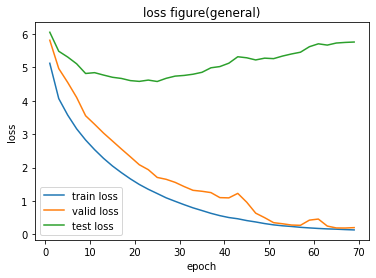

In [27]:
# 可视化
# loss
fig, ax = plt.subplots()
plt.title('loss figure(general)')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(loss_x, train_loss_y, label='train loss')
plt.plot(loss_x, valid_loss_y, label='valid loss')
plt.plot(loss_x, test_loss_y, label='test loss' )
plt.legend()
plt.show()

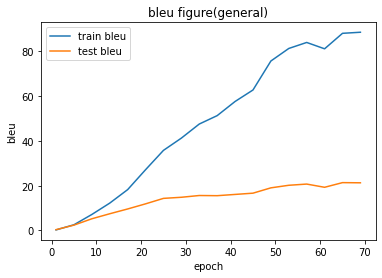

In [28]:
# 可视化
# bleu
fig, ax = plt.subplots()
plt.title('bleu figure(general)')
plt.xlabel('epoch')
plt.ylabel('bleu')
plt.plot(bleu_x, train_bleu_y, label='train bleu')
plt.plot(bleu_x, test_bleu_y, label='test bleu')
plt.legend()
plt.show()

In [29]:
print("best valid loss：", best_valid_loss)
# 加载最优权重
model.load_state_dict(torch.load("en2ch-attn-model.pt"))

best valid loss： 0.16828834125427694


<All keys matched successfully>

In [30]:
font = FontProperties(fname=r"./simheittf/simheittf/simhei.ttf", size=11)

def att_show(input, output, attn): 
    fig, ax = plt.subplots()
    fig.set_figheight(len(output))
    fig.set_figwidth(len(input))
    im = ax.imshow(attn)
    ax.set_xticks(np.arange(len(input)))
    ax.set_yticks(np.arange(len(output)))
    ax.set_xticklabels(input, fontproperties=font)
    ax.set_yticklabels(output, fontproperties=font)
    plt.colorbar(im)
    plt.show()

[原文]
['it', 'took', 'me', 'half', 'an', 'hour', 'to', 'work', 'out', 'this', 'problem', '.', '<eos>']
[人工翻译]
['我花', '了', '一个半', '小时', '的', '时间', '解决', '这个', '问题', '。']
[机器翻译]
['我花', '了', '一个半', '小时', '的', '时间', '解决', '这个', '问题', '。']



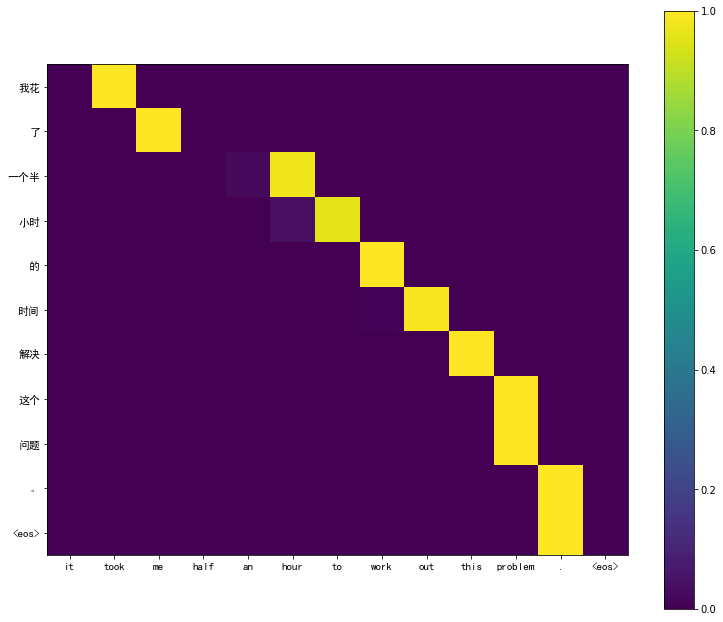

[原文]
['in', 'this', 'case', ',', 'the', 'adjective', 'goes', 'before', 'the', 'noun', '.', '<eos>']
[人工翻译]
['在', '这种', '情况', '下', '，', '形容词', '放在', '名词', '前面', '。']
[机器翻译]
['在', '这种', '情况', '下', '，', '形容词', '在', '名词', '前面', '。']



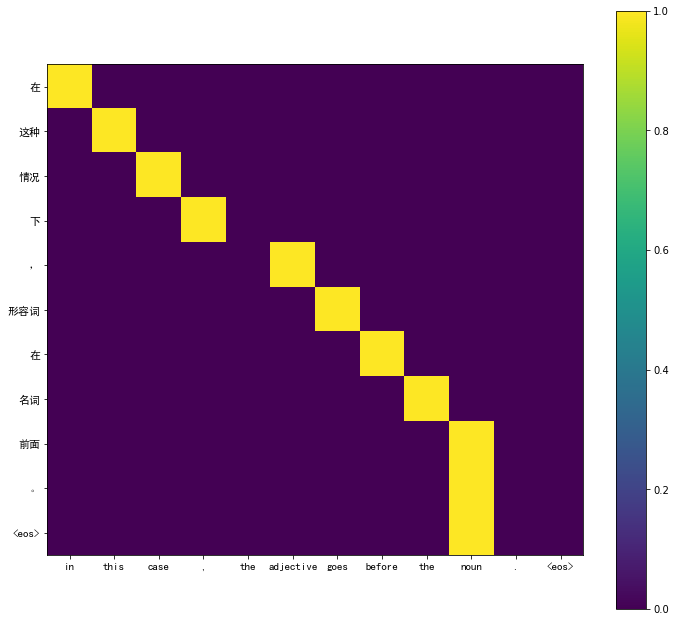

[原文]
['they', 'did', "n't", 'act', 'quickly', '.', '<eos>']
[人工翻译]
['他们', '没有', '立刻', '行动', '。']
[机器翻译]
['他们', '没有', '立刻', '出门', '。']



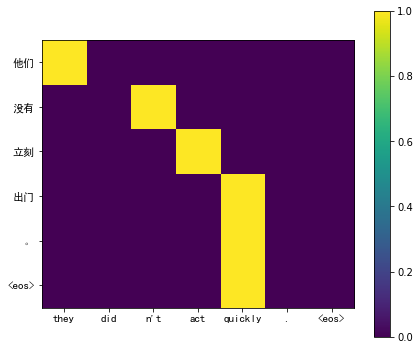

[原文]
['she', 'tried', 'to', 'commit', 'suicide', '.', '<eos>']
[人工翻译]
['她', '企图', '自杀', '。']
[机器翻译]
['她', '试图', '试图', '。']



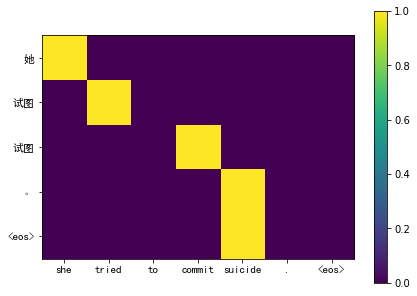

[原文]
['this', 'sofa', 'takes', 'up', 'too', 'much', 'space', '.', '<eos>']
[人工翻译]
['这张', '沙发', '占', '了', '太', '多', '空间', '。']
[机器翻译]
['这张', '沙发', '占', '了', '太', '多', '空间', '。']



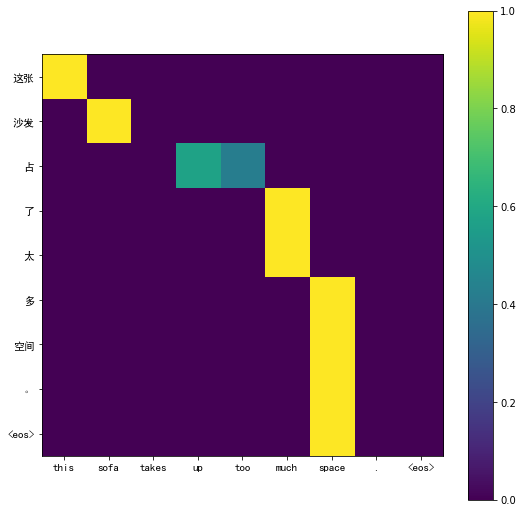

[原文]
['have', 'you', 'ever', 'eaten', 'japanese', 'food', '?', '<eos>']
[人工翻译]
['你', '吃', '过', '日本料理', '吗', '？']
[机器翻译]
['你', '吃', '过', '日本料理', '吗', '？']



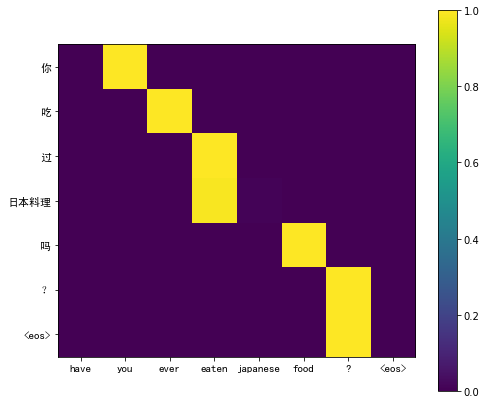

[原文]
['i', 'do', "n't", 'plan', 'to', 'stay', 'for', 'very', 'long', '.', '<eos>']
[人工翻译]
['我', '没有', '打算', '停留', '太久', '。']
[机器翻译]
['我', '没有', '打算', '停留', '太久', '。']



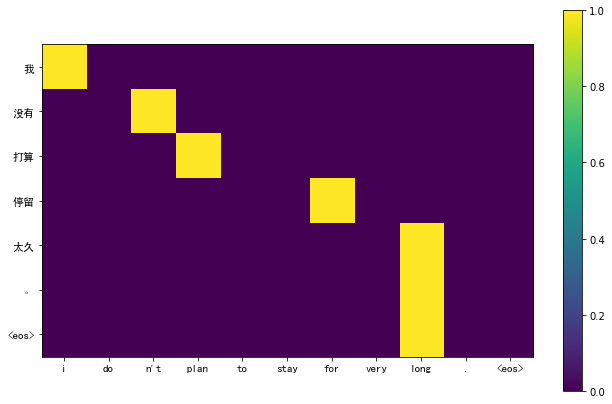

[原文]
['tom', 'was', 'afraid', 'to', 'ask', 'for', 'help', '.', '<eos>']
[人工翻译]
['汤姆', '不敢', '求助', '。']
[机器翻译]
['汤姆', '不敢', '求助', '。']



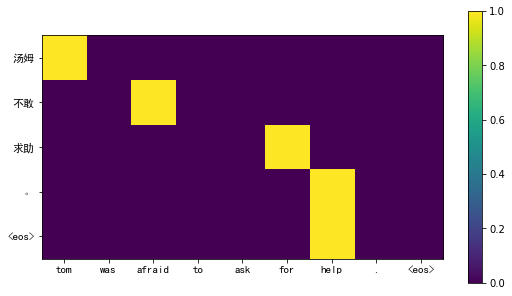

[原文]
['i', 'was', 'just', 'trying', 'to', 'protect', 'you', '.', '<eos>']
[人工翻译]
['我', '只是', '试著', '保护', '你', '。']
[机器翻译]
['我', '只是', '试著', '保护', '你', '。']



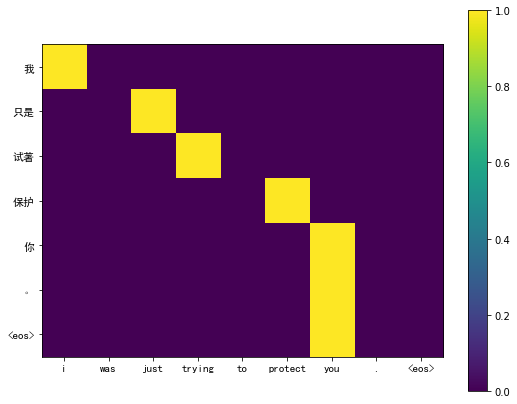

[原文]
['i', 'truly', 'do', 'not', 'understand', 'the', 'question', '.', '<eos>']
[人工翻译]
['我', '真的', '不', '懂', '这个', '问题', '。']
[机器翻译]
['我', '真的', '不', '懂', '这个', '问题', '。']



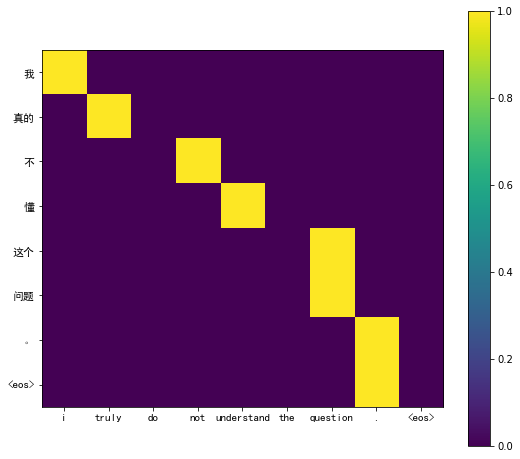

In [31]:
random.seed(2020)
for i in random.sample(range(len(en_num_data)), 10):  # 随机看10个
    en_tokens = list(filter(lambda x: x!=1, en_num_data[i]))  # 过滤零
    ch_tokens = list(filter(lambda x: x!=3 and x!=1, ch_num_data[i]))  # 和机器翻译作对照
    sentence = [en_TEXT.vocab.itos[t] for t in en_tokens]
    print("[原文]")
    print(sentence)
    translation = [ch_TEXT.vocab.itos[t] for t in ch_tokens]
    print("[人工翻译]")
    print(translation)
    test_sample = {}
    test_sample["src"] = torch.tensor(en_tokens, dtype=torch.long, device=device).reshape(-1, 1)
    test_sample["src_len"] = [len(en_tokens)]
    print("[机器翻译]")
    output_tokens, attn_info = translate(model, test_sample, ch_TEXT.vocab.itos)
    print(output_tokens, end="\n\n")
    att_show(sentence, output_tokens+['<eos>'], attn_info)